In [17]:
from toolbox import dB2lin, dBm2watts, get_angle, watts2dBm, pack2dict
import numpy as np
import pandas as pd
from antenna import AntennaArray
import seaborn as sns 
import matplotlib.pyplot as plt
import sota_optimizer
import simulation
# Plotting style.
sns.set_palette("colorblind")
sns.set_style("whitegrid", {"axes.edgecolor": "black"})
sns.despine(top=False, right=False, left=False, bottom=False)
sns.set_context("paper", font_scale=1.4)

<Figure size 432x288 with 0 Axes>

#### Example of beam sweeping with and without the RIS.

In [15]:
pip install cvxpy

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Adrian\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [18]:
'''
Network topology (coordinates <x, y, z>).
'''
bs_loc  = np.array([0, 0, 0]) # Base station.
ris_loc = np.array([45, 5, 0]) # RIS.
ue_loc  = np.array([50, 0, 0]) # User equipment.
'''
Channel parameters.
'''
Ptx_dBm = 25
A_dB = -30 # 30 dB path loss attenuation.
alpha_bs2ris = 2.8 # Attenuation coefficient between base station and RIS.
alpha_ris2ue = 2.8 # ... between RIS and user equipment.
alpha_bs2ue  = 3.5 # ... between BS and user equipment.
'''
Antenna parameters.
''' 
element_gain_dBi = 1 # Antenna element gain.
fc = 30e9 # Carrier frequency in Hz.
wavelen = 3e8/fc # Wave length.
nx, ny, nz = 1, 8, 1 # Distribution of antenna elements. 
M = int(nx*ny*nz) # Number of antenna elements.
dx = dy = dz = wavelen * 0.5 # Distance between antenna elements.
nhbeams = 9 # Number of horizontal beams.
nvbeams = 1 # Number of vertical beams.
hangmin, hangmax = -45, 45 # Horizontal angles.
vangmin, vangmax = 0, 0 # Vertical angles.
antenna = AntennaArray(
    wavelen, nx, ny, nz, dx, dy, dz, hbeams=nhbeams, vbeams=nvbeams,
    hangmin=hangmin, hangmax=hangmax, vangmin=vangmin, vangmax=vangmax)
'''
RIS parameters.
'''
N = 250
'''
Quantization.
'''
nbits = 4

In [19]:
def calc_prx(Cd, Cr, G, w_bs2ue, w_bs2ris, Gamma, Theta,directpath=True):
    '''
    This returns the received power in watts.
    '''
    # Don't ask me why this is the conjugate. It just works as in the 
    #   reference MATLAB code.
    psi = np.conj(np.matmul(Cd.T, w_bs2ue))
    # Don't ask me why this is the conjugate. It just works as in the 
    #   reference MATLAB code.
    A = np.conj(np.matmul(Cr.T, Gamma))
    B = np.matmul(A, Theta)
    C = np.matmul(B, G)
    D = np.matmul(C, w_bs2ris)
    if directpath:
        prx = np.power(np.linalg.norm(D + psi), 2)
    else:
        prx = np.power(np.linalg.norm(D), 2)
    return prx


def get_ris_coefficients(w_bs2ue, w_bs2ris, M, N, ptxDbm, Cd, Cr, G, nBits, type_ris):
    if type_ris == "fixed":
        beta = np.ones(N)
        Gamma = np.diag(beta)
        theta = np.zeros(N)
        Theta = np.diag(np.exp(1j*theta))
    elif type_ris == "none":
        beta = np.zeros(N)
        Gamma = np.diag(beta)
        theta = np.zeros(N)
        Theta = np.diag(theta)
    elif type_ris == "optimized":
        
        # Received power.
        Gamma, Theta = optimize_ris.optimize(
            PdBm=ptxDbm, 
            w_bs2ue=w_bs2ue, 
            w_bs2ris=w_bs2ris, 
            M=M, 
            N=N, 
            Cd=Cd, 
            Cr=Cr, 
            G=G, 
            optimizer="sota",
            nbits=nBits,
        )
    else:
        assert True == False, \
            "Error, invalid RIS type! It should be either none or fixed."
    return Gamma, Theta

In [27]:
# Distances for the two links: (a) BS -> UE and (b) BS -> RIS -> UE.
d_bs2ris = np.linalg.norm(bs_loc-ris_loc)
d_ris2ue = np.linalg.norm(ris_loc-ue_loc)
d_bs2ue  = np.linalg.norm(bs_loc-ue_loc)
# Path loss coefficient.
A = dB2lin(A_dB)
# Transmit power.
p = np.sqrt(dBm2watts(Ptx_dBm)/M) * np.ones((M, 1)) # Transmit power per element.o
# Channels.
# Direct channel, BS -> UE.
cd = np.sqrt(A*np.power(d_bs2ue, -alpha_bs2ue)/2.)*simulation.gen_fading(M,1)#np.ones((M, 1))#(np.random.randn(M, 1) + 1j*np.random.randn(M, 1))
# Indirect channel, RIS -> UE.
cr = np.sqrt(A*np.power(d_ris2ue, -alpha_ris2ue)/2.)*simulation.gen_fading(N,1)#np.ones((N, 1))#(np.random.randn(N, 1) + 1j*np.random.randn(N, 1))
# RIS channel, RIS -> UE.
g  = np.sqrt(A*np.power(d_bs2ris, -alpha_bs2ris)/2.)*simulation.gen_fading(N,M)#np.ones((N, M))#(np.random.randn(N, M) + 1j*np.random.randn(N, M))
# Beam sweeping.

logs = {"prx_dBm": [], "beam_angle": [], "ris": []}

gain = []
phis = np.linspace(-np.pi/2, np.pi/2, 200) # Horizontal angles.

for type_ris in ["none", "fixed"]:
    for codebook_id in antenna.codebook_ids:
        
        w_steer, steering_angle = antenna.steering_vec(codebook_id)
        w_steer = w_steer.conj()
        
        phi2ue  = get_angle(ue_loc-bs_loc, ue_loc-bs_loc, unit="deg")
        phi2ris = get_angle(ris_loc-bs_loc, ue_loc-bs_loc, unit="deg")
        af_bs2ue = antenna.calc_array_factor( # Radiation pattern.
            theta=np.pi/2, phi=phi2ue
        )
        af_bs2ris = antenna.calc_array_factor( # Radiation pattern.
            theta=np.pi/2, phi=phi2ris
        )
        
        w_bs2ue = np.multiply(p, af_bs2ue @ w_steer)
        w_bs2ris = np.multiply(p, af_bs2ris @ w_steer)
        # Received power.
        gamma, theta = get_ris_coefficients(w_bs2ue, w_bs2ris, M, N, Ptx_dBm, cd, cr, g, nbits, type_ris)
        #print(gamma)
        #print(theta)
        prx = calc_prx(cd, cr, g, w_bs2ue, w_bs2ris, gamma, theta)
        prx_dBm = watts2dBm(prx)
        
        _ = pack2dict(logs, [prx_dBm, steering_angle[1], type_ris])
        print(steering_angle)
        #print(codebook_id)

(90.0, -45.0)
(90.0, -33.75)
(90.0, -22.5)
(90.0, -11.25)
(90.0, 0.0)
(90.0, 11.25)
(90.0, 22.5)
(90.0, 33.75)
(90.0, 45.0)
(90.0, -45.0)
(90.0, -33.75)
(90.0, -22.5)
(90.0, -11.25)
(90.0, 0.0)
(90.0, 11.25)
(90.0, 22.5)
(90.0, 33.75)
(90.0, 45.0)


In [31]:
for codebook_id in antenna.codebook_ids:
    print(p+prx_dBm)

[[-103.96301073]
 [-103.96301073]
 [-103.96301073]
 [-103.96301073]
 [-103.96301073]
 [-103.96301073]
 [-103.96301073]
 [-103.96301073]]
[[-103.96301073]
 [-103.96301073]
 [-103.96301073]
 [-103.96301073]
 [-103.96301073]
 [-103.96301073]
 [-103.96301073]
 [-103.96301073]]
[[-103.96301073]
 [-103.96301073]
 [-103.96301073]
 [-103.96301073]
 [-103.96301073]
 [-103.96301073]
 [-103.96301073]
 [-103.96301073]]
[[-103.96301073]
 [-103.96301073]
 [-103.96301073]
 [-103.96301073]
 [-103.96301073]
 [-103.96301073]
 [-103.96301073]
 [-103.96301073]]
[[-103.96301073]
 [-103.96301073]
 [-103.96301073]
 [-103.96301073]
 [-103.96301073]
 [-103.96301073]
 [-103.96301073]
 [-103.96301073]]
[[-103.96301073]
 [-103.96301073]
 [-103.96301073]
 [-103.96301073]
 [-103.96301073]
 [-103.96301073]
 [-103.96301073]
 [-103.96301073]]
[[-103.96301073]
 [-103.96301073]
 [-103.96301073]
 [-103.96301073]
 [-103.96301073]
 [-103.96301073]
 [-103.96301073]
 [-103.96301073]]
[[-103.96301073]
 [-103.96301073]
 [-103.

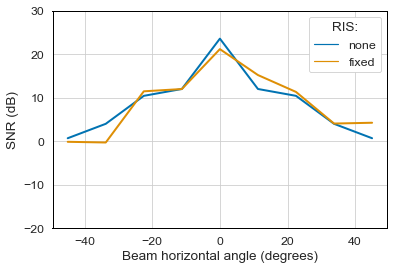

In [21]:
df = pd.DataFrame(logs)

noise_floor = -90 # in dBm.
df["SNR (dB)"] = df["prx_dBm"] - noise_floor

ax = sns.lineplot(
    data=df,
    x="beam_angle",
    y="SNR (dB)",
    hue="ris",
    lw=2,
    # markers=True,
    # style="ris",
    # markersize=8,
    # markevery=10,
)
_ = plt.ylim([-20, 30])
_ = plt.ylabel("SNR (dB)")
_ = plt.xlabel("Beam horizontal angle (degrees)")
_ = plt.legend(title="RIS:", framealpha=1.0)

# Beam pattern for a given BS steering vector

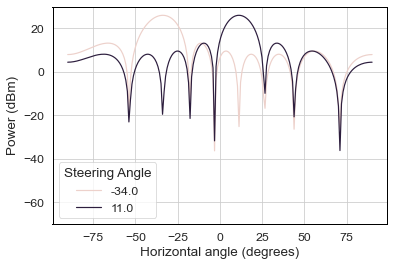

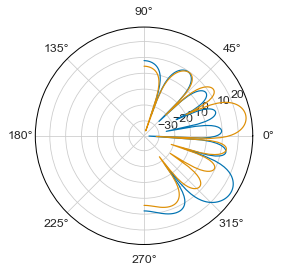

In [22]:
logs = {"prx_dBm": [], "phi": [], "steering_angle": []}

phis = np.linspace(-np.pi/2, np.pi/2, 200) # Horizontal angles.

for codebook_id in antenna.codebook_ids[[1,5]]:

    w_steer, steering_angle = antenna.steering_vec(codebook_id)
    #print(steering_angle)
    w_steer = w_steer.conj()
    
    for phi in phis:
        element_gain = 10*np.power(10, element_gain_dBi/10) # dBi -> linear.
        m = int(nx*ny*nz) # Number of antenna elements.
        p = np.sqrt(dBm2watts(Ptx_dBm)/m) * np.ones((m, 1)) * element_gain # Power spread over antenna elements.
        w = antenna.calc_array_factor( # Radiation pattern.
                theta=np.pi/2, phi=phi
            )
        w = w @ w_steer
        w = np.multiply(w, p)
        g = np.power(np.linalg.norm(np.sum(w)), 2) # Gain.
        gain = 10*np.log10(g)
        
        _ = pack2dict(logs, [gain, np.rad2deg(phi), np.round(steering_angle[1])])

df_sweep = pd.DataFrame(logs)

noise_floor = -90 # in dBm.

df_sweep["SNR (dB)"] = df_sweep["prx_dBm"] - noise_floor
        
_ = plt.figure()
ax = sns.lineplot(data=df_sweep,
    x="phi",
    y="prx_dBm",
    hue="steering_angle")
_ = plt.ylabel("Power (dBm)")
_ = plt.ylim([-70, 30])
_ = plt.xlabel("Horizontal angle (degrees)")
_ = plt.legend(loc='lower left', title='Steering Angle')

grouped = df_sweep.groupby(by=["steering_angle"])

_ = plt.figure()

for key in grouped.groups.keys():
    _ = plt.polar(np.deg2rad(grouped.get_group(key)["phi"]), grouped.get_group(key)["prx_dBm"])

_ = plt.show()


## Beam pattern for a given RIS steering vector 

(90.0, -45.0)
(90.0, -32.14285714285714)
(90.0, -19.285714285714285)
(90.0, -6.428571428571431)
(90.0, 6.428571428571431)
(90.0, 19.285714285714292)
(90.0, 32.14285714285714)
(90.0, 45.0)


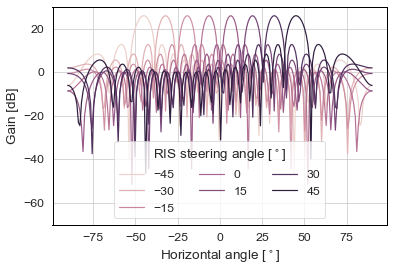

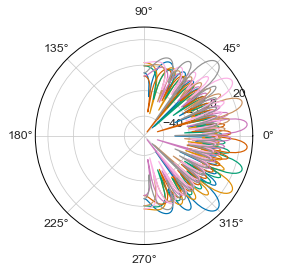

In [23]:
logs = {"prx_dBm": [], "phi": [], "steering_angle": []}

phis = np.linspace(-np.pi/2, np.pi/2, 200) # Horizontal angles.

'''
RIS Array parameters.
''' 
element_gain_dBi = 1 # Antenna element gain.
fc = 30e9 # Carrier frequency in Hz.
wavelen = 3e8/fc # Wavelength.
rx, ry, rz = 1, 20, 20 # Distribution of antenna elements. 
R = int(nx*ny*nz) # Number of antenna elements.
dx = dy = dz = wavelen * 0.5 # Distance between antenna elements.
nhbeams = 8 # Number of horizontal beams.
nvbeams = 1 # Number of vertical beams.
hangmin, hangmax = -45, 45 # Horizontal angles.
vangmin, vangmax = 0, 0 # Vertical angles.
ris = AntennaArray(
    wavelen, rx, ry, rz, dx, dy, dz, hbeams=nhbeams, vbeams=nvbeams,
    hangmin=hangmin, hangmax=hangmax, vangmin=vangmin, vangmax=vangmax)

for codebook_id in ris.codebook_ids:

    w_steer, steering_angle = ris.steering_vec(codebook_id)
    print(steering_angle)
    w_steer = w_steer.conj()
    
    for phi in phis:
        element_gain = 10*np.power(10, element_gain_dBi/10) # dBi -> linear.
        m = int(nx*ny*nz) # Number of antenna elements.
        #This power is incorrect, we simply assume that the transmit power is exactly the power that lands on the RIS
        p = np.sqrt(dBm2watts(Ptx_dBm)/m) * np.ones((m, 1)) * element_gain # Power spread over antenna elements.
        w = ris.calc_array_factor( # Radiation pattern.
                theta=np.pi/2, phi=phi
            )
        w = w @ w_steer
        w = np.multiply(w, p)
        g = np.power(np.linalg.norm(np.sum(w)), 2) # Gain.
        gain = 10*np.log10(g)
        
        _ = pack2dict(logs, [gain, np.rad2deg(phi), np.round(steering_angle[1])])

df_sweep = pd.DataFrame(logs)

noise_floor = -90 # in dBm.

df_sweep["SNR (dB)"] = df_sweep["prx_dBm"] - noise_floor
        
_ = plt.figure()
ax = sns.lineplot(data=df_sweep,
    x="phi",
    y="prx_dBm",
    hue="steering_angle")
_ = plt.ylabel("Gain [dB]")
_ = plt.ylim([-70, 30])
_ = plt.xlabel("Horizontal angle [$^\circ$]")
_ = plt.legend(loc='lower center', title='RIS steering angle [$^\circ$]',ncol=3)

plt.savefig("./ris_sweep_codebook.pdf", dpi='figure', format='pdf')

grouped = df_sweep.groupby(by=["steering_angle"])

_ = plt.figure()

for key in grouped.groups.keys():
    _ = plt.polar(np.deg2rad(grouped.get_group(key)["phi"]), grouped.get_group(key)["prx_dBm"])
#_ = plt.legend(loc='lower left', title='RIS steering angle [$^\circ$]',ncol=3)
_ = plt.show()

In [ ]:
# RIS-BS Beam Sweeping Results

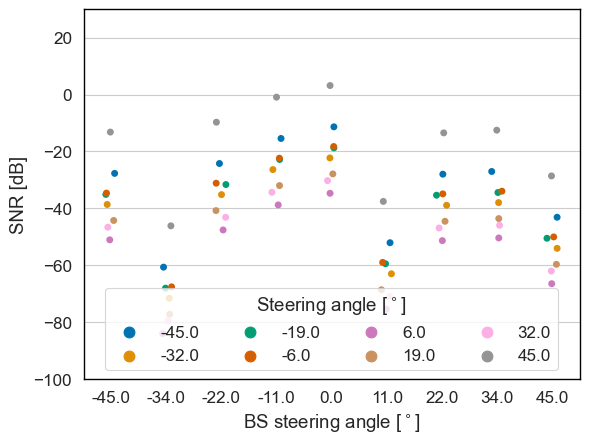

In [ ]:
logs = {"prx_dBm": [], "bs_steering_angle": [], "ris_steering_angle": []}

alpha_bs2ue  = 3.5 # ... between BS and user equipment.

#Global angles
phi2ue  = get_angle(ue_loc-bs_loc, ue_loc-bs_loc, unit="deg")
phi2ris = get_angle(ris_loc-bs_loc, ue_loc-bs_loc, unit="deg")
af_bs2ue = antenna.calc_array_factor( # Radiation pattern.
    theta=np.pi/2, phi=phi2ue
)
af_bs2ris = antenna.calc_array_factor( # Radiation pattern.
    theta=np.pi/2, phi=phi2ris
)

ris_glob_rot = -90

phi2ris2ue = get_angle(ue_loc-ris_loc, ue_loc-bs_loc, unit="deg") + ris_glob_rot
af_ris2ue = ris.calc_array_factor( # Radiation pattern.
                theta=np.pi/2, phi=phi2ris2ue
            )
ris_element_gain = 10*np.power(10, element_gain_dBi/10) # dBi -> linear.
mr = int(rx*ry*rz) # Number of antenna elements.
pr = np.sqrt(1/mr) * np.ones((mr, 1)) * ris_element_gain # Power spread over antenna elements.

cd = np.sqrt(A*np.power(d_bs2ue, -alpha_bs2ue)/2.)*simulation.gen_fading(M,1)

cr = np.sqrt(A*np.power(d_ris2ue, -alpha_ris2ue)/2.)*simulation.gen_fading(mr,1)#np.ones((N, 1))#(np.random.randn(N, 1) + 1j*np.random.randn(N, 1))
# RIS channel, RIS -> UE.
g  = np.sqrt(A*np.power(d_bs2ris, -alpha_bs2ris)/2.)*simulation.gen_fading(mr,M)#np.ones((N, M))#(np.random.randn(N, M) + 1j*np.random.randn(N, M))
# Beam sweeping.

for bs_codebook_id in antenna.codebook_ids:
    for ris_codebook_id in ris.codebook_ids:
        
        w_steer, steering_angle = antenna.steering_vec(bs_codebook_id)
        w_steer = w_steer.conj()

        w_bs2ue = np.multiply(p, af_bs2ue @ w_steer)
        w_bs2ris = np.multiply(p, af_bs2ris @ w_steer)

        w_steer_ris, steering_angle_ris = ris.steering_vec(ris_codebook_id)
        w_steer_ris = w_steer_ris.conj()
        
        w_ris2ue = np.multiply(pr, af_ris2ue @ w_steer_ris)
        
        #Get the RIS coefficients
        gamma = np.absolute(w_ris2ue)
        Gamma = np.diag(gamma.squeeze())
        theta = np.angle(w_ris2ue, deg=False)
        Theta = np.diag(theta.squeeze())
        
        # Received power.
        prx = calc_prx(cd, cr, g, w_bs2ue, w_bs2ris, Gamma, Theta, directpath=False)
        prx_dBm = watts2dBm(prx)
        
        _ = pack2dict(logs, [prx_dBm, np.round(steering_angle[1]), np.round(steering_angle_ris[1])])
        #print(steering_angle)

df_ris_sweep = pd.DataFrame(logs)

noise_floor = -90 # in dBm.

df_ris_sweep["SNR (dB)"] = df_ris_sweep["prx_dBm"] - noise_floor

_ = plt.figure()
ax = sns.stripplot(data=df_ris_sweep,
    x="bs_steering_angle",
    y="SNR (dB)",
    hue="ris_steering_angle")
_ = plt.ylabel("SNR [dB]")
_ = plt.ylim([-100, 30])
_ = plt.xlabel("BS steering angle [$^\circ$]")
_ = plt.legend(loc='lower center', title='Steering angle [$^\circ$]',ncol=4)

plt.savefig("./bs_ris_joint_sweep.pdf", dpi='figure', format='pdf')

#sns.stripplot(data=tips, x="total_bill", y="day", hue="day", legend=False)
